# Working with cloud-optimized GeoTIFF data

This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or can be accessed from GitHub:

*Note to dev: adjust links in the badges and remove this message!*
*Tools to generate badges: https://mybinder.org/*

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Deltares-research/IDP-handbook/main?urlpath=%2Fdoc%2Ftree%2Fidp_handbook%2Ftutorials%2Fjupyter-notebook-template.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)]()
[![colab](https://colab.research.google.com/assets/colab-badge.svg)]()
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/Deltares-research/IDP-handbook/blob/main/idp_handbook/tutorials/jupyter-notebook-template.ipynb)


*Add a short description of this tutorial notebook:*  
*Purpose - what can you use it for?*  
*What can you learn from this tutorial?*  
*Which data is used?*  
*How can you customize it?*  
*Limitations - what should you not use it for?*  

This notebook demonstrates how to access and visualize the cloud-optimized GeoTIFF data from the IDP STAC catalog.

## Preparation work

### Prepare your environment

*Insert here any necessary instructions to set-up the environment if running locally (not through e.g. Binder)*

### Load libraries

In [36]:
import os
import fsspec
from typing import List, Dict
from copy import deepcopy
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import numpy as np
#import odc.stac
import pystac
import rioxarray as rxr
import shapely
import stac_geoparquet
import xarray as xr
from ipyleaflet import Map, basemaps
import plotly.express as px
import plotly.graph_objects as go

In [2]:
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+notebook'

### User-defined settings

*Example: coordinates, bounding box, region, polygon etc.*

In [10]:
bbox = [2.2,51.02,6.74,53.75] # from https://boundingbox.klokantech.com/
polygon = shapely.geometry.box(*bbox)

We can convert the specified geometry to a geodataframe:

In [11]:
gdf = gpd.GeoDataFrame(
    [{"name": "bbox", "geometry": polygon}],
    crs="EPSG:4326"
)

The geodataframe can be visualized on an interactive map:

In [ ]:
lons, lats = polygon.exterior.xy
min_lon, min_lat, max_lon, max_lat = polygon.bounds
center_lon = (min_lon + max_lon) / 2
center_lat = (min_lat + max_lat) / 2

# Create a Scattermapbox figure (polygon outline)
fig = go.Figure(go.Scattermap(
    lon=list(lons),
    lat=list(lats),
    mode='lines',          # only draw edges
    line=dict(color='blue', width=3),
    fill=None,
))

# Update layout with automatic center & zoom
fig.update_layout(
    map_style="open-street-map",
    map_center={"lat": center_lat, "lon": center_lon},
    map_zoom=6,
    margin={"r":0,"t":0,"l":0,"b":0}
)
fig.show()

## Access the data

*Explain how the data will be accessed, followed by code*

### Specify data directory

In [ ]:
# # Directory to store data
# DATADIR = './data_dir/'
# # Create this directory if it doesn't exist
# os.makedirs(DATADIR, exist_ok=True)

### Retrieve data

In [25]:
# This needs to be put in another script?
# function to put items in dataframe
def items_to_dataframe(items: List[Dict]) -> pd.DataFrame:
    """STAC items to Pandas dataframe.

    Args:
        items (List[Dict]): _description_

    Returns:
        pd.DataFrame: _description_
    """
    _items = []
    for i in items:
        _i = deepcopy(i)
        _items.append(_i)
    df = pd.DataFrame(pd.json_normalize(_items))
    return df

def get_all_items_with_progress(collection, batch_size=100):
    """
    Get all items from a collection with progress tracking.
    This works even when the collection doesn't support search API.
    """
    print(f"Loading items from collection: {collection.id}")
    
    try:
        # Get the item iterator
        items_iter = collection.get_items()
        
        all_items = []
        batch = []
        
        for i, item in enumerate(items_iter, 1):
            batch.append(item)
            
            # Process in batches to show progress and manage memory
            if len(batch) >= batch_size:
                all_items.extend(batch)
                print(f"Loaded {len(all_items)} items...")
                batch = []
        
        # Add remaining items
        if batch:
            all_items.extend(batch)
            
        print(f"Finished loading {len(all_items)} total items")
        return all_items
        
    except Exception as e:
        print(f"Error loading items: {e}")
        return []


def get_collection_df(collection):
    name = "name"#collection
    print("Available assets in collection:")
    for asset_name, asset in collection.get_assets().items():
        print(f"  - {asset_name}: {asset.href}")

    # Try to find a parquet asset first, fallback to item loading
    if "geoparquet-stac-items" in collection.get_assets():
        print(f"Using fast parquet method for {name}...")
        items_df = pd.read_parquet(collection.get_assets()["geoparquet-stac-items"].href)
        print(f"Loaded {len(items_df)} items from parquet")
    else:
        print("\nNo parquet asset found, using get_items() with progress tracking...")
        items = get_all_items_with_progress(collection, batch_size=50)
        items_df = items_to_dataframe([i.to_dict() for i in items])
        print(f"Converted to DataFrame with {len(items_df)} rows")

    print("DataFrame info:")
    print(f"Shape: {items_df.shape}")

        
    return items_df

In [32]:
catalog = pystac.Catalog.from_file(
    "https://storage.googleapis.com/coclico-data-public/coclico/coclico-stac/catalog.json"
)

#list(catalog.get_children())

In [31]:
ar6_col = catalog.get_child("slp6")
items_ar6_df = get_collection_df(ar6_col)
items_ar6_df.head()

Available assets in collection:
  - thumbnail: https://storage.googleapis.com/coclico-data-public/coclico/assets/thumbnails/slp6.png
  - geoparquet-stac-items: https://coclico.blob.core.windows.net/items/slp6.parquet
Using fast parquet method for name...
Loaded 4494 items from parquet
DataFrame info:
Shape: (4494, 17)


,type,stac_version,stac_extensions,id,geometry,bbox,links,assets,collection,proj:bbox,proj:shape,proj:geometry,proj:transform,datetime,proj:code,ssp,slr_ens
0,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.0
1,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.1\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.1
2,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens0.5\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,0.5
3,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens1.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,1.0
4,Feature,1.1.0,[https://stac-extensions.github.io/projection/...,ssp=1-26\slr_ens2.0\2020.tif,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00...,"[-180.5, -90.5, 179.5, 90.5]","[{'href': '../../../collection.json', 'rel': '...",{'data': {'href': 'https://storage.googleapis....,slp6,"[-180.5, -90.5, 179.5, 90.5]","[181, 360]","{'coordinates': [[[179.5 -90.5], [179.5 90.5]...","[1.0, 0.0, -180.5, 0.0, 1.0, -90.5]",2020-01-01,EPSG:4326,1-26,2.0


In [34]:
# filter items in datasets
ar_df_dict = {"AR6": items_ar6_df}
# define variables
ens_list = ["5", "50", "95"]  # ensemble list to look into
yrs_list = np.arange(1970, 2200, 10)  # years to look into (step of 10 years from 1970)
key_list = ["CCS", "YRS", "ENS", "href"]
SLR_dicts = {"AR6": {}}

# index AR6 dataframe on criteria
for ar in ["AR6"]:
    SLR_dicts[ar] = {key: [] for key in key_list}
    for i, row in ar_df_dict[ar].iterrows():
        id = row.id
        enss = str(id).split("\\")[1].split("ens")[-1]  # ensemble
        yrs = int(str(id).split("\\")[2][0:4])  # yrs
        ccs = str(id).split("\\")[0].split("=")[-1] # ccs
        if str(float(enss)) in [str(float(x)) for x in ens_list] and yrs in yrs_list:  # constraining read ensembles and years
            SLR_dicts[ar]["CCS"].append(ccs)
            SLR_dicts[ar]["YRS"].append(yrs)
            SLR_dicts[ar]["ENS"].append(str(float(enss)))
            if "assets" in row:
                SLR_dicts[ar]["href"].append(row.assets["data"]["href"])
            else:
                SLR_dicts[ar]["href"].append(row["assets.data.href"])

    # filter AR6 dataframe and STAC items on index
    ar_df_dict[ar] = pd.DataFrame(SLR_dicts[ar])

ar_df_dict["AR6"]

,CCS,YRS,ENS,href
0,1-26,2020,5.0,https://storage.googleapis.com/coclico-data-pu...
1,1-26,2020,50.0,https://storage.googleapis.com/coclico-data-pu...
2,1-26,2020,95.0,https://storage.googleapis.com/coclico-data-pu...
3,1-26,2030,5.0,https://storage.googleapis.com/coclico-data-pu...
4,1-26,2030,50.0,https://storage.googleapis.com/coclico-data-pu...
...,...,...,...,...
121,5-85,2140,50.0,https://storage.googleapis.com/coclico-data-pu...
122,5-85,2140,95.0,https://storage.googleapis.com/coclico-data-pu...
123,5-85,2150,5.0,https://storage.googleapis.com/coclico-data-pu...
124,5-85,2150,50.0,https://storage.googleapis.com/coclico-data-pu...


In [35]:
yr = 2100  # set year
ens = 50  # set ensemble [0-100]
ccs5 = "26"  # set climate change scenario for AR5
ccs6 = "1-26"  # set climate change scenario for AR6

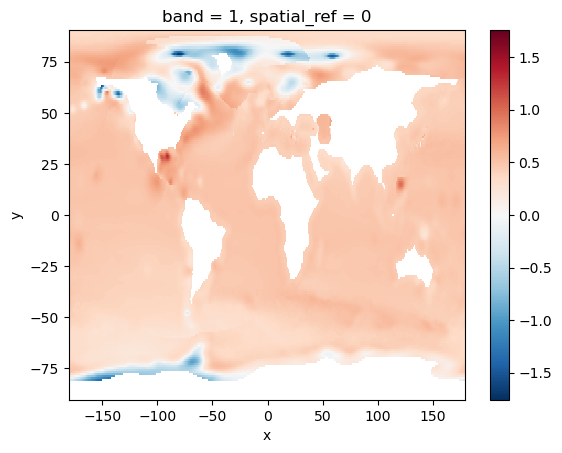

In [38]:
df = ar_df_dict["AR6"]
row_selected = df[(df['CCS'] == ccs6) & (df['YRS'] == yr) & (df['ENS'] == str(float(ens)))].iloc[0]
ar6_item = rxr.open_rasterio(row_selected.href, masked=True)
ar6_item = ar6_item / 1000
ar6_item.plot()

## Explore and visualize the data

Explore the data

In [ ]:
# code

## References

*List references*

## Contributors

*List of contributors*